# コード3-1：ギレスピーアルゴリズムによる確率シミュレーションの実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

ギレスピーアルゴリズムによる確率シミュレーションの実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

- GillespieSSA2 https://github.com/rcannood/GillespieSSA2
- tidyr https://tidyr.tidyverse.org/

In [13]:
## 必要があればインストール
# install.packages(c("GillespieSSA2", "tidyr", "ggplot2", "dplyr", "doParallel"))

In [2]:
rm(list = ls(all = TRUE))
library(GillespieSSA2)
library(ggplot2)
library(tidyr)
library(dplyr)
library(doParallel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



## ギレスピーアルゴリズム


式(3.6)

$$
\frac{d V_{\text{det}}(t)}{dt} = k_{\text{det}} V_{\text{att}}(t) - k_{\text{att}} V_{\text{det}}(t) \\
\frac{d V_{\text{att}}(t)}{dt} = k_{\text{att}} V_{\text{det}}(t) - k_{\text{det}} V_{\text{att}}(t) - k_{\text{int}} V_{\text{att}}(t) \\
\frac{d V_{\text{int}}(t)}{dt} = k_{\text{int}} V_{\text{att}}(t) - k_{\text{ccc}} \left( 1 - \frac{V_{\text{ccc}}(t)}{K} \right) V_{\text{int}}(t) - k_{\text{di}} V_{\text{int}}(t) \\
\frac{d V_{\text{ccc}}(t)}{dt} = k_{\text{ccc}} \left( 1 - \frac{V_{\text{ccc}}(t)}{K} \right) V_{\text{int}}(t) - k_{\text{dc}} V_{\text{ccc}}(t)
$$

で表されるHBVの侵入動態についてギレスピーアルゴリズムを用いた確率シミュレーションを行う。

ここで、表(3.2)から$k_{\text{det}} = 3.38, k_{\text{att}} = 0.16, k_{\text{int}} = 3.07, k_{\text{ccc}} = 0.65, k_{\text{di}} = 1.94, k_{\text{dc}} = 0.12, K = 3.73$である。

HBVの侵入動態の確率シミュレーションで更新される系は、4つの変数

$$V_{\text{det}}(t), V_{\text{att}}(t), V_{\text{int}}(t), V_{\text{ccc}}(t)$$

と、モデルで定義される７つの反応

$$
\begin{cases}
E_1(t) = k_{\text{det}} V_{\text{att}}(t) \\
E_2(t) = k_{\text{att}} V_{\text{det}}(t) \\
E_3(t) = k_{\text{int}} V_{\text{att}}(t) \\
E_4(t) = k_{\text{ccc}} V_{\text{int}}(t) \\
E_5(t) = \frac{k_{\text{ccc}} V_{\text{ccc}}(t) V_{\text{int}}(t)}{K} \\
E_6(t) = k_{\text{di}} V_{\text{int}}(t) \\
E_7(t) = k_{\text{dc}} V_{\text{ccc}}(t)
\end{cases}
$$

で構成される。

ここでは、高速な計算が可能な`GillespieSSA2`ライブラリを用いた。  

In [3]:
## パラメータ
## k_det, k_att, k_int, k_ccc, k_di, k_dc, K
pars <- c(3.38, 0.16, 3.07, 0.65, 1.94, 0.12, 3.73)
names(pars) <- c("k_det", "k_att", "k_int", "k_ccc", "k_di", "k_dc", "K")

### 直接法

In [4]:
initial_state <- c(V_det = 1, V_att = 130, V_int = 1, V_ccc = 1)

reactions <- list(
    #        propensity function     effects                       name for reaction
    reaction(~k_det*V_att, c(V_att = -1, V_det = +1), "E_1"),
    reaction(~k_att*V_det, c(V_det = -1, V_att = +1), "E_2"),
    reaction(~k_int*V_att, c(V_att = -1, V_int = +1), "E_3"),
    reaction(~k_ccc*V_int, c(V_int = -1, V_ccc = +1), "E_4"),
    reaction(~k_ccc*V_ccc*V_int/K, c(V_ccc = -1, V_int = +1), "E_5"),
    reaction(~k_di*V_int, c(V_int = -1), "E_6"),
    reaction(~k_dc*V_ccc, c(V_ccc = -1), "E_7")
)

model_HBV <- function(pars, method = ssa_exact()) {
    ssa(
        initial_state = initial_state,
        reactions = reactions,
        params = pars,
        method = method,
        final_time = 70/24,
        census_interval = .01,
        verbose = FALSE
    )
}

In [5]:
time_start <- Sys.time()

## 並列計算のための並列バックエンドの登録
cores <- getOption("mc.cores", detectCores())
cl <- makeCluster(cores)
registerDoParallel(cl)

## 10回のシミュレーション
results_HBV <- foreach(i = 1:10, .packages = 'GillespieSSA2') %dopar% {
    model_HBV(pars = pars)
}

## クラスターの終了 !途中で止まったなどで実行されない場合は個別に実行!
stopCluster(cl)
rm(cl)

time_end <- Sys.time()
time_gillespiessa <- time_end - time_start
print(paste("経過時間", time_gillespiessa))

[1] "経過時間 5.07139849662781"


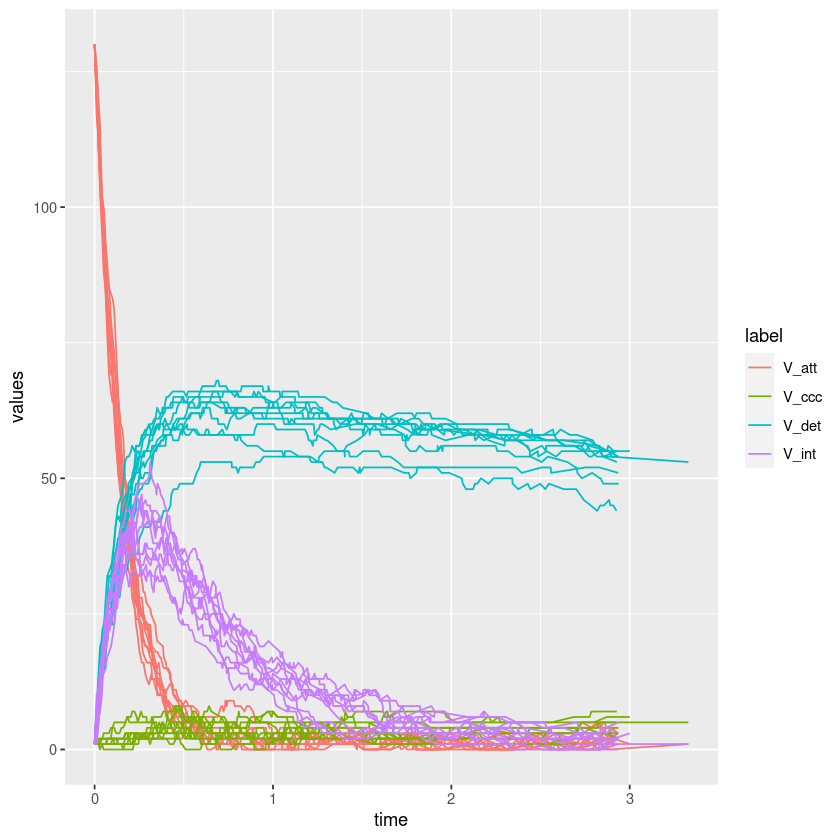

In [6]:
data_plot <- data.frame()
for (i in 1:10) {
    data_temp <- pivot_longer(cbind(as.data.frame(results_HBV[[i]]$state), time = results_HBV[[i]]$time),
                              cols = -time, names_to = "label", values_to = "values")
    data_plot <- rbind(data_plot, cbind(data_temp, run = paste("run", i, sep = "_")))
}

data_plot <- mutate(data_plot, label_run = paste(label, run, sep = "_"))

ggplot(data = data_plot,
       aes(x = time, y = values, group = label_run, color = label)) +
    geom_line()

In [7]:
## ODEの数値解
d_results_HBV <- model_HBV(pars = pars, method = ode_em(noise_strength = 0))

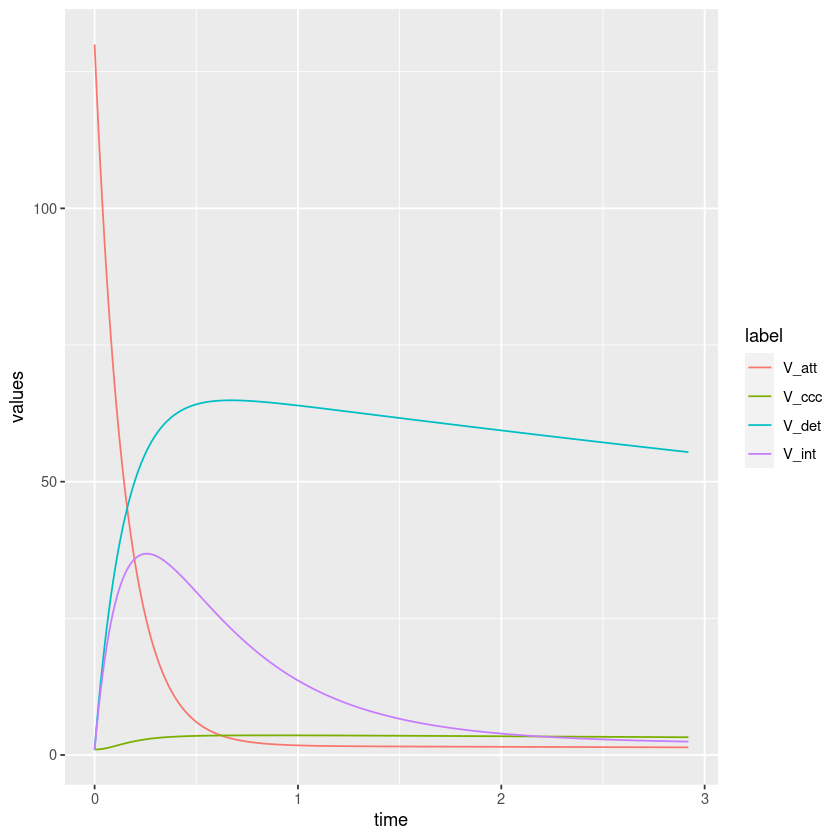

In [8]:
data_plot <- pivot_longer(cbind(as.data.frame(d_results_HBV$state), time = d_results_HBV$time),
                        cols = -time, names_to = "label", values_to = "values")

ggplot(data = data_plot,
       aes(x = time, y = values, color = label)) +
    geom_line()

### tau-leap法

In [9]:
time_start <- Sys.time()

## 並列計算のための並列バックエンドの登録
cores <- getOption("mc.cores", detectCores())
cl <- makeCluster(cores)
registerDoParallel(cl)

## 10回のシミュレーション
results_HBV_tauleaping <- foreach(i = 1:10, .packages = 'GillespieSSA2') %dopar% {
    model_HBV(pars = pars, method = ssa_etl(tau = 0.01))
}

## クラスターの終了 !途中で止まったなどで実行されない場合は個別に実行!
stopCluster(cl)
rm(cl)

time_end <- Sys.time()
time_gillespiessatauleaping <- time_end - time_start
print(paste("経過時間", time_gillespiessatauleaping))

[1] "経過時間 5.08500981330872"


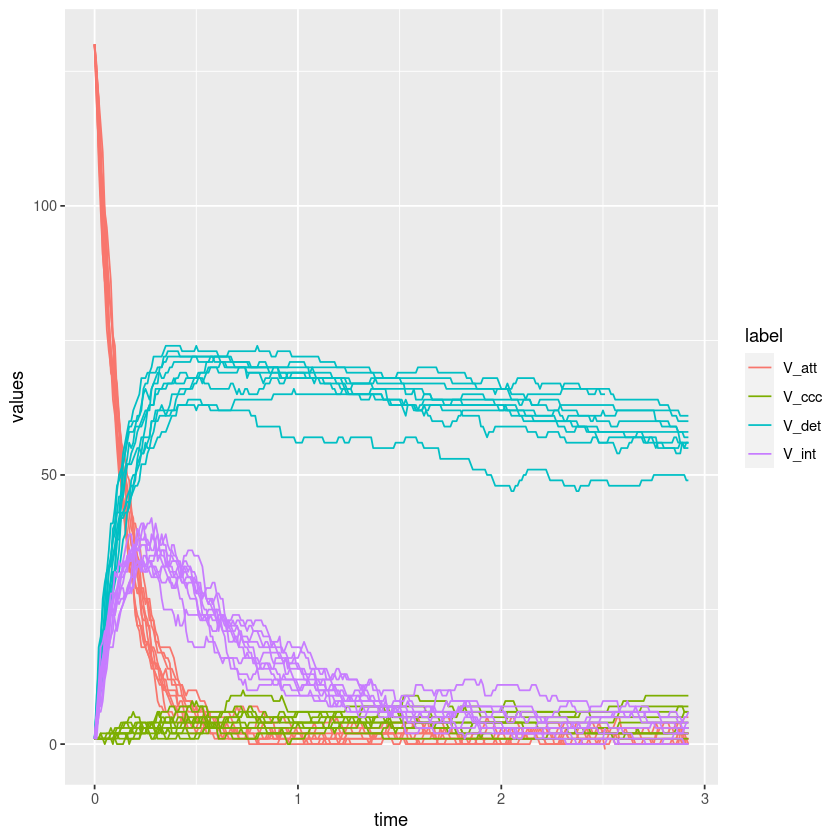

In [10]:
data_plot <- data.frame()
for (i in 1:10) {
    data_temp <- pivot_longer(cbind(as.data.frame(results_HBV_tauleaping[[i]]$state), time = results_HBV_tauleaping[[i]]$time),
                              cols = -time, names_to = "label", values_to = "values")
    data_plot <- rbind(data_plot, cbind(data_temp, run = paste("run", i, sep = "_")))
}

data_plot <- mutate(data_plot, label_run = paste(label, run, sep = "_"))

ggplot(data = data_plot,
       aes(x = time, y = values, group = label_run, color = label)) +
    geom_line()

In [12]:
## 計算時間の比較
## 絶対数が少ない計算ではほとんど変わらないようだ（計算時間は個体数に依存するので、個体数が多い状況ではtau leap法などが早い）
print(paste("直接法：", time_gillespiessa))
print(paste("tau-leap法：", time_gillespiessatauleaping))

[1] "直接法： 5.07139849662781"
[1] "tau-leap法： 5.08500981330872"
